In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import json
import re

dist_results_path = "../data/cloud_logs/dist_res.csv"

seq_par_results_dir = "../data/logs/"
plots_dir= "../plots/report/"

versions_res = [
    "Result (JSON) - 1",
    "Result (JSON) - cache code - 2",
    "Result (JSON) - cache + less features + optimizations - 3",
    "Result (JSON) - cache + less features + optimizations + entropy - 4"
    ]

In [2]:
# utility functions

def to_dict(s):
    return json.loads(re.sub(r'(\w+):', r'"\1":', s))

def to_json(row, col):
    return to_dict(row[col]) if not pd.isna(row[col]) and row[col] not in ["Failed", "X"] else row[col]

def dispatch(row, col, k):
    return row[col][k] if not pd.isna(row[col]) and row[col] not in ["Failed", "X"] else row[col]

Load seq and par results direclty from logs.

In [3]:
from os import listdir
from os.path import isfile, join

def get_res(f):
    with open(f, "rb") as f:
        return f.read().decode("utf-8") 

### load seq and par results from log files
par_seq_df = pd.DataFrame(
    data = [[*f[:-4].split("_"), get_res(join(seq_par_results_dir, f))] for f in listdir(seq_par_results_dir) if isfile(join(seq_par_results_dir, f))],
    columns = ["Size", "Mode", "Feat type", "Result (JSON) - 0"]
)

par_seq_df["Size"] = par_seq_df["Size"].astype(int)
par_seq_df = par_seq_df.sort_values(by=["Size", "Mode", "Feat type"])
par_seq_df["Result (JSON) - 0"] = par_seq_df.apply(lambda row: to_json(row, "Result (JSON) - 0"), axis=1)

for k in par_seq_df["Result (JSON) - 0"][0].keys():
    par_seq_df[k] = par_seq_df.apply(lambda row: dispatch(row, "Result (JSON) - 0", k), axis=1)

par_seq_df = par_seq_df.replace(['cont'], 'mixed')

par_seq_df.head(5)

,Size,Mode,Feat type,Result (JSON) - 0,trainTime,testTime,score,unknown,unknownRelative
0,1024,par,binned,"{'trainTime': 1.4174834, 'testTime': 0.1363207...",1.417483,0.136321,0.813725,34,0.166667
1,1024,par,cat,"{'trainTime': 1.806403, 'testTime': 0.0869674,...",1.806403,0.086967,0.712195,48,0.234146
2,1024,par,mixed,"{'trainTime': 3.4196436, 'testTime': 0.0425462...",3.419644,0.042546,0.843902,20,0.097561
3,1024,seq,binned,"{'trainTime': 0.2452623, 'testTime': 0.0118568...",0.245262,0.011857,0.813725,34,0.166667
4,1024,seq,cat,"{'trainTime': 0.2592121, 'testTime': 0.0089301...",0.259212,0.008930,0.712195,48,0.234146


Load dist results and split into separate df based on implementation version

In [4]:
dist_df = pd.read_csv(dist_results_path, sep=";").loc[:, ["Size", "Workers", *versions_res]]

dist_df["Mode"] = "dist"
dist_df["Feat type"] = "binned"

dist_df.head(5)

,Size,Workers,Result (JSON) - 1,Result (JSON) - cache code - 2,Result (JSON) - cache + less features + optimizations - 3,Result (JSON) - cache + less features + optimizations + entropy - 4,Mode,Feat type
0,1024,1,"{ trainTime: 80.39794886, testTime: 0.0225498...","{ trainTime: 55.01343861, testTime: 0.0233809...","{ trainTime: 45.053363084, testTime: 0.015219...","{ trainTime: 47.178302182, testTime: 0.032509...",dist,binned
1,1024,2,"{ trainTime: 91.735758818, testTime: 0.018419...","{ trainTime: 57.825253678, testTime: 0.020315...","{ trainTime: 57.775892882, testTime: 0.031243...","{ trainTime: 48.706505525, testTime: 0.029688...",dist,binned
2,1024,3,"{ trainTime: 113.031210898, testTime: 0.01993...","{ trainTime: 62.352801879, testTime: 0.015099...","{ trainTime: 64.052160869, testTime: 0.022260...","{ trainTime: 56.320322632, testTime: 0.018686...",dist,binned
3,1707,1,X,X,X,X,dist,binned
4,1707,2,X,"{ trainTime: 124.965440232, testTime: 0.03189...","{ trainTime: 111.226497364, testTime: 0.01857...","{ trainTime: 108.972697466, testTime: 0.03400...",dist,binned


In [5]:
dist_df.shape

(51, 8)

In [6]:
dist_df_1 = dist_df.loc[dist_df[versions_res[0]].notna()].loc[:, ["Size", "Workers", versions_res[0], "Mode", "Feat type"]]
dist_df_2 = dist_df.loc[dist_df[versions_res[1]].notna()].loc[:, ["Size", "Workers", versions_res[1], "Mode", "Feat type"]]
dist_df_3 = dist_df.loc[dist_df[versions_res[2]].notna()].loc[:, ["Size", "Workers", versions_res[2], "Mode", "Feat type"]]
dist_df_4 = dist_df.loc[dist_df[versions_res[3]].notna()].loc[:, ["Size", "Workers", versions_res[3], "Mode", "Feat type"]]

In [7]:
for i, dist_df_n in enumerate([dist_df_1, dist_df_2, dist_df_3, dist_df_4]):   
    results_col = versions_res[i]

    dist_df_n[results_col] = dist_df_n.apply(lambda row: to_json(row, results_col), axis=1)

    for k in dist_df_n[results_col][0].keys():
        dist_df_n[k] = dist_df_n.apply(lambda row: dispatch(row, results_col, k), axis=1)

    print(dist_df_n.head(2))

   Size  Workers                                  Result (JSON) - 1  Mode  \
0  1024        1  {'trainTime': 80.39794886, 'testTime': 0.02254...  dist   
1  1024        2  {'trainTime': 91.735758818, 'testTime': 0.0184...  dist   

  Feat type  trainTime  testTime     score unknown unknownRelative  
0    binned  80.397949   0.02255  0.813725      34        0.166667  
1    binned  91.735759  0.018419  0.813725      34        0.166667  
   Size  Workers                     Result (JSON) - cache code - 2  Mode  \
0  1024        1  {'trainTime': 55.01343861, 'testTime': 0.02338...  dist   
1  1024        2  {'trainTime': 57.825253678, 'testTime': 0.0203...  dist   

  Feat type  trainTime  testTime     score unknown unknownRelative  
0    binned  55.013439  0.023381  0.813725      35        0.171569  
1    binned  57.825254  0.020316  0.813725      35        0.171569  
   Size  Workers Result (JSON) - cache + less features + optimizations - 3  \
0  1024        1  {'trainTime': 45.053363084

## Seq and Par performances

In [12]:
# utility functions

def get_cat_plot(data, x, y, hue, xlabel, ylabel, legend_title, filename, log=True):
    sns.set_style("whitegrid")

    g = sns.catplot(
        data=data , kind="bar",
        errorbar=None,
        x=x, y=y, hue=hue,
        legend="full", palette="muted")

    if (log):
        g.set(yscale="log")
    
    plt.xticks(rotation=45)
    g.set_axis_labels(xlabel, ylabel)
    g.legend.set_title(legend_title)

    g.figure.savefig(filename, dpi=1200, bbox_inches='tight')

    plt.show()


def get_line_plot(data, x, y, hue, xlabel, ylabel, filename, log=True):
    g = sns.lineplot(
        data=data,
        x=x, y=y, hue=hue,
        legend="full",
        palette= "muted",
        marker="o")

    if (log):
        g.set(yscale="log")
    
    plt.xticks(rotation=45)
    
    g.set_xlabel(xlabel)
    g.set_ylabel(ylabel)

    g.figure.savefig(filename)

    plt.show()

In [13]:
par_seq_df.columns

Index(['Size', 'Mode', 'Feat type', 'Result (JSON) - 0', 'trainTime',
       'testTime', 'score', 'unknown', 'unknownRelative'],
      dtype='object')

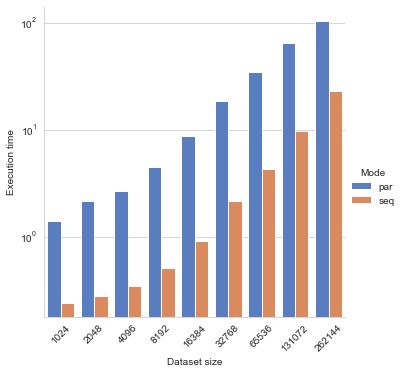

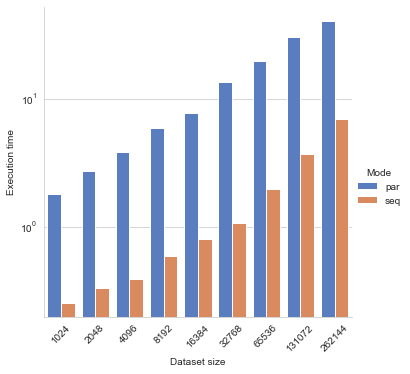

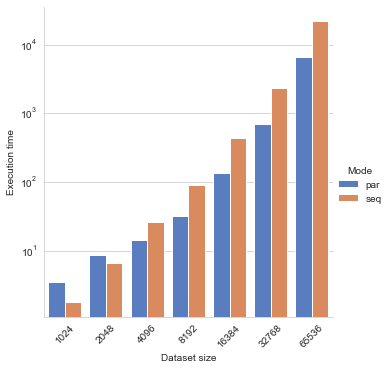

In [14]:
for feat_type in par_seq_df["Feat type"].unique():
    get_cat_plot(
        par_seq_df.loc[par_seq_df["Feat type"] == feat_type],
        "Size","trainTime", "Mode",
        "Dataset size", "Execution time",
        "Mode",
        f"{plots_dir}seq_par_{feat_type}_BAR.png")

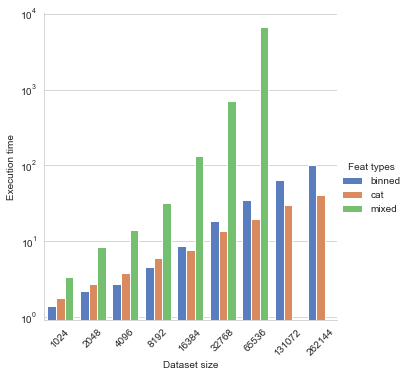

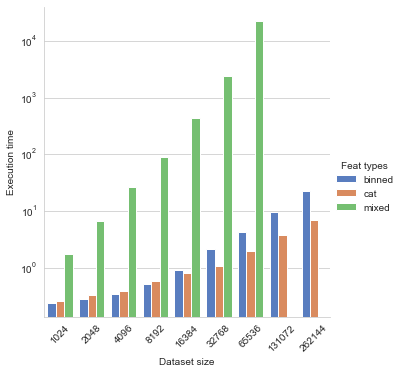

In [15]:
for mode in par_seq_df["Mode"].unique(): 
    get_cat_plot(
        par_seq_df.loc[par_seq_df["Mode"] == mode],
        "Size", "trainTime", "Feat type",
        "Dataset size", "Execution time",
        "Feat types",
        f"{plots_dir}{mode}_BAR.png"
        )

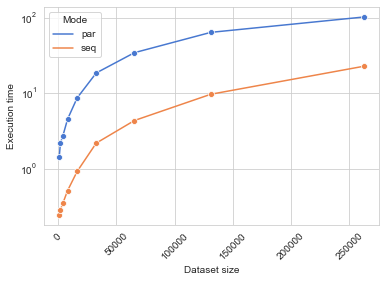

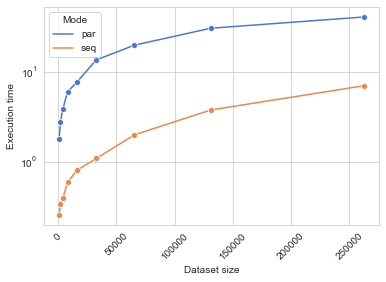

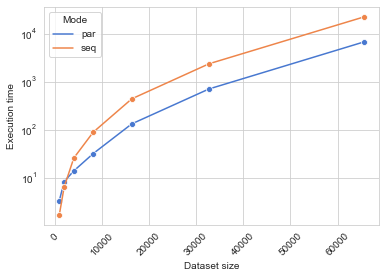

In [16]:
for feat_type in par_seq_df["Feat type"].unique():
    get_line_plot(
        par_seq_df.loc[par_seq_df["Feat type"] == feat_type],
        "Size", "trainTime", "Mode",
        "Dataset size", "Execution time",
        f"{plots_dir}seq_par_{feat_type}_LINE.png"
        )

## Scalability performance -  main algorithm (4)

Performance on different numbers of nodes with specific sample

In [18]:
# dist_df_1 - base
# dist_df_2 - with cache
# dist_df_3 - with cache, less features and more similar to paper
# dist_df_4 - main (as version 3 + sequential entropy)

main_sizes = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144]

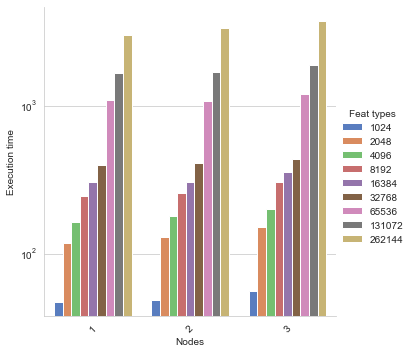

In [19]:
get_cat_plot(
        dist_df_4.loc[dist_df_4["Size"].isin(main_sizes)],
        "Workers", "trainTime", "Size",
        "Nodes", "Execution time",
        "Feat types",
       f"{plots_dir}dist_4_BAR.png"
        )

## Comparison mapreduce versions

1 worker

In [21]:
dist_df_1.sort_values(by=["Size", "Workers"])

dist_df_1["version"] = 1
dist_df_2["version"] = 2
dist_df_3["version"] = 3
dist_df_4["version"] = 4

In [22]:
cols = ["Size", "Workers", "trainTime", "version"]
dist_train_ds = pd.concat([dist_df_1[cols], dist_df_2[cols], dist_df_3[cols], dist_df_4[cols]])
dist_train_ds = dist_train_ds.reset_index()
dist_train_ds = dist_train_ds.loc[dist_train_ds["Size"].isin(main_sizes)]
dist_train_ds

,index,Size,Workers,trainTime,version
0,0,1024,1,80.397949,1
1,1,1024,2,91.735759,1
2,2,1024,3,113.031211,1
6,6,2048,1,222.465692,1
7,7,2048,2,231.318699,1
...,...,...,...,...,...
196,43,131072,2,1689.472213,4
197,44,131072,3,1884.872822,4
201,48,262144,1,2972.924035,4
202,49,262144,2,3341.834399,4


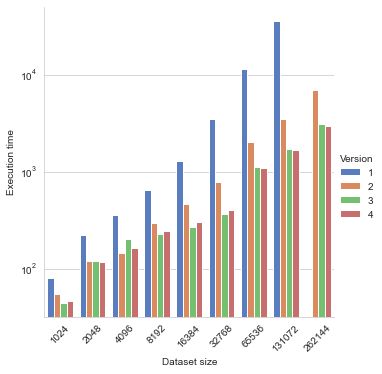

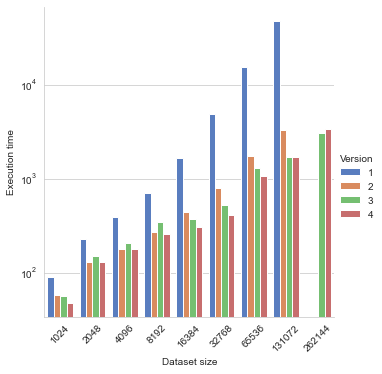

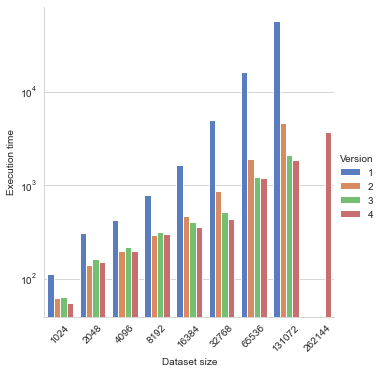

In [25]:
for worker in dist_train_ds["Workers"].unique():
    get_cat_plot(
        data=dist_train_ds.loc[dist_train_ds["Workers"]== worker].loc[~dist_train_ds["trainTime"].isin(["Failed", "X"])],
        x="Size", y="trainTime", hue="version",
        xlabel="Dataset size", ylabel="Execution time",
        legend_title="Version",
        filename=f"{plots_dir}dist_{worker}_workers_BAR.png")

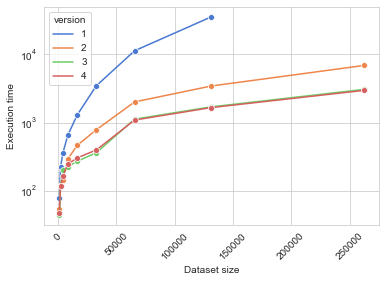

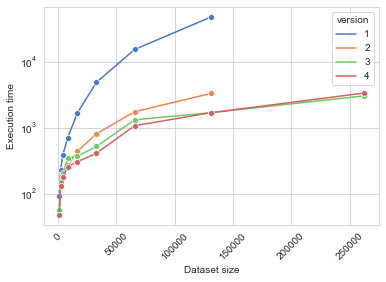

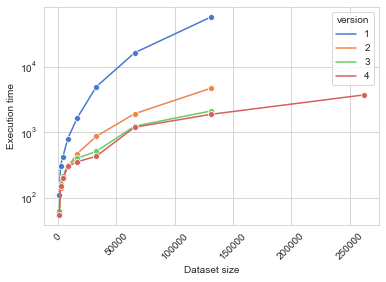

In [26]:
# bar plot no of nodes on x,exec time in seconds on y, legends num instances
# Draw a nested barplot by species and sex
for worker in dist_train_ds["Workers"].unique():
    get_line_plot(
        data=dist_train_ds.loc[dist_train_ds["Workers"]== worker].loc[~dist_train_ds["trainTime"].isin(["Failed", "X"])],
        x="Size", y="trainTime", hue="version",
        xlabel="Dataset size", ylabel="Execution time",
        filename=f"{plots_dir}dist_{worker}_workers_LINE.png")

## Weak scalability

In [28]:
weak_df =dist_df_4[["Size", "Workers", "trainTime"]].set_index(["Size", "Workers"])

sizes_w = [[
    (1024, 1),
    (2048, 2),
    (3413, 3),
]
,[
    (4096,  1),
    (8192,  2),
    (13653, 3),
]
,[
    (16384, 1),
    (32768, 2),
    (54613, 3),
]
,[
    (65536,  1),
    (131072, 2),
    (218453, 3)
]]

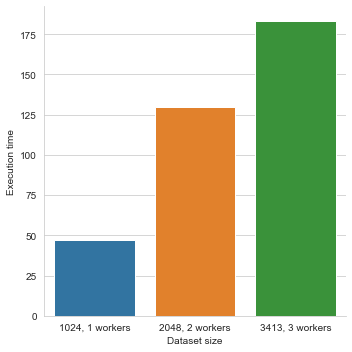

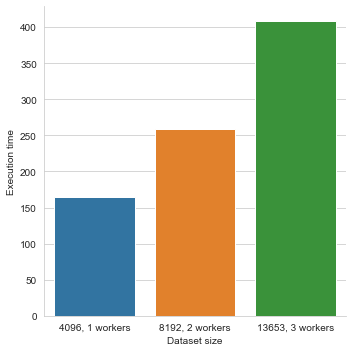

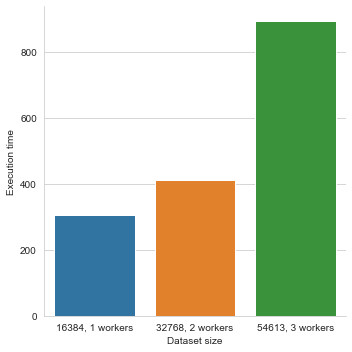

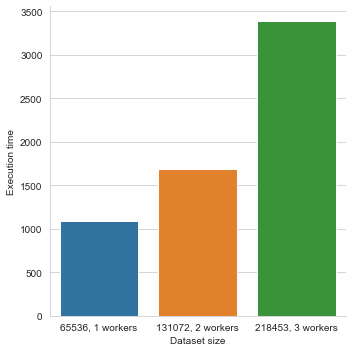

In [29]:
for sw_indices in sizes_w:
    tmp_df = weak_df.loc[sw_indices, :].reset_index()
    
    sns.set_style("whitegrid")

    g = sns.catplot(
        data=tmp_df.loc[~tmp_df["trainTime"].isin(["Failed", "X"])], kind="bar",
        x="Size", y="trainTime",
        legend="full")

    g.set_xticklabels([f"{s_w[0]}, {s_w[1]} workers" for s_w in sw_indices])
    g.set_axis_labels("Dataset size", "Execution time")

    g.figure.savefig(f"{plots_dir}dist_weak_scalability_{sw_indices[0][0]}_{sw_indices[0][1]}BAR.png", dpi=1200, bbox_inches='tight')

    plt.show()

    

Strong Scalability

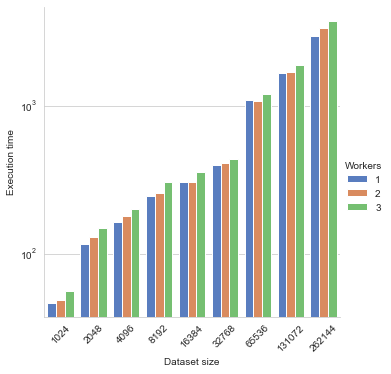

In [31]:
get_cat_plot(
        data=dist_df_4.loc[dist_df_4["Size"].isin(main_sizes)].loc[~dist_df_4["trainTime"].isin(["Failed", "X"])],
        x="Size", y="trainTime", hue="Workers",
        xlabel="Dataset size", ylabel="Execution time",
        legend_title="Workers",
        filename=f"{plots_dir}dist_strong_scalability_BAR.png")

In [32]:
#latest comparison

df = par_seq_df.loc[par_seq_df["Feat type"] == "binned"]
df = pd.concat([df, dist_df_4.loc[dist_df_4["Workers"] == 1.0]]).reset_index().set_index(["Size", "Mode"])

In [33]:
df = df["trainTime"].reset_index().sort_values(["Size"])

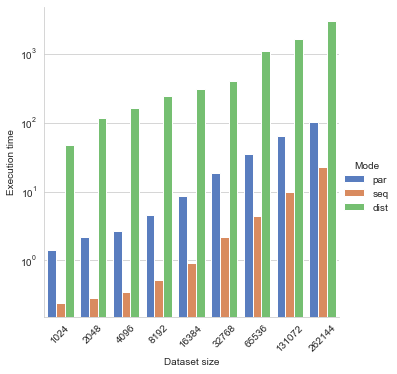

In [34]:
get_cat_plot(
        data=df.loc[df["Size"].isin(main_sizes)],
        x="Size", y="trainTime", hue="Mode",
        xlabel="Dataset size", ylabel="Execution time",
        legend_title="Mode",
        filename=f"{plots_dir}final_comparison_BAR.png")